In [1]:
import numpy as np
import pandas as pd
import pickle
from tqdm.notebook import tqdm
from sklearn.metrics import mean_absolute_error, mean_squared_error, r2_score
from prophet import Prophet
import sys
sys.path.append('../utils')
from utils import load_processed_data

# Prophet Model

Uses Facebook Prophet package to forecast speed of a single sensor using a decomposible time series model that takes into account many types of seasonality.

Read more: https://facebook.github.io/prophet/docs/quick_start.html#python-api



### Setup

In [2]:
station_meta = pd.read_csv('../data/processed/fwy_405_n_ds/meta.csv')

In [3]:
_, _, station_data = load_processed_data('../data/processed/rdp_ds')

station_data.head()

,715898,716016,716023,716026,716028,716067,716069,716078,716081,716142,...,776773,776825,776826,776843,776845,776945,776981,777066,777068,777169
2021-01-01 00:00:00,70.2,65.1,68.1,65.0,68.9,67.4,68.9,71.0,68.1,69.2,...,69.3,69.1,65.7,65.3,65.0,65.0,69.8,68.6,69.1,66.0
2021-01-01 00:05:00,70.0,64.9,69.6,65.0,55.5,67.7,70.8,70.0,67.3,70.4,...,69.1,68.9,65.8,66.6,64.9,65.0,69.6,68.4,68.9,65.8
2021-01-01 00:10:00,69.9,65.2,71.2,64.9,51.0,68.3,70.9,70.3,68.3,67.8,...,69.2,69.0,65.8,66.3,65.0,65.1,69.7,68.9,69.0,65.9
2021-01-01 00:15:00,69.8,65.2,68.9,64.8,46.8,67.1,69.0,70.0,68.7,69.5,...,68.8,68.7,65.9,67.1,65.0,65.1,69.4,68.8,68.7,65.6
2021-01-01 00:20:00,69.8,65.1,67.4,64.8,63.6,66.8,68.7,70.5,68.3,67.2,...,68.8,68.6,65.6,67.8,65.0,64.9,69.3,68.9,68.6,65.5


### Select Sensor

Choose sensor ID and split into train/test

In [4]:
from random import choice

In [6]:
# good example stations to try
#   717711  (difficult)
#   716659  (many random outliers)
#   761455  (periodic)
#   772455  (very periodic)

# select a station number to use
STATION = choice(station_data.columns)


# use may, june as train data and july as test data
train_data = station_data[STATION][station_data.index < pd.to_datetime('2021-07-01')]
test_data = station_data[STATION][station_data.index >= pd.to_datetime('2021-07-01')]

### Model

In [8]:
from time import time

In [9]:
# convert to fbprophet format
df = pd.DataFrame({'ds': train_data.index, 'y': train_data.values})
df.head()

# initialize model
m = Prophet(yearly_seasonality=False)
start = time()
m.fit(df)
end = time()
train_time = end - start

Initial log joint probability = -31.9988
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
Error evaluating model log probability: Non-finite gradient.
Error evaluating model log probability: Non-finite gradient.

      58        214714   1.59562e-05       460.145           1           1       96   
Optimization terminated normally: 
  Convergence detected: relative gradient magnitude is below tolerance


In [10]:
# with open('./trained/prophet/prophet.dat', 'wb') as f:
#     pickle.dump(m, f)

### Evaluate

In [11]:
# predict test data
future = pd.DataFrame({'ds': train_data.index.union(test_data.index)})
forecast = m.predict(future)

preds = forecast[forecast['ds'].isin(test_data.index)]['yhat'].values

In [15]:
import plotly.graph_objects as go

In [ ]:
# results
mae = mean_absolute_error(test_data.values, preds)
rmse = mean_squared_error(test_data.values, preds, squared=False)
mse = mean_squared_error(test_data.values, preds)
print('MAE:  %.3f' % mae)
print('RMSE: %.3f' % rmse)
print('MSE: %.3f' % mse)

fig = go.Figure()
fig.add_trace(go.Line(x=test_data.index, y=test_data, name='True Values'))
fig.add_trace(go.Line(x=test_data.index, y=preds, name='Predicted Values'))
fig.update_layout(
    title="Prophet Forecast Results",
    xaxis_title="Time",
    yaxis_title="Forecast")

In [21]:
# fig.write_html('../plots/prophet.html')

In [13]:
# with open('./trained/prophet/metrics_prophet.dat', 'wb') as f:
#     metrics = {'mse': mse, 'rmse': rmse, 'r2': r2_score(test_data.values, preds), 'train_time': train_time}
#     pickle.dump(metrics, f)

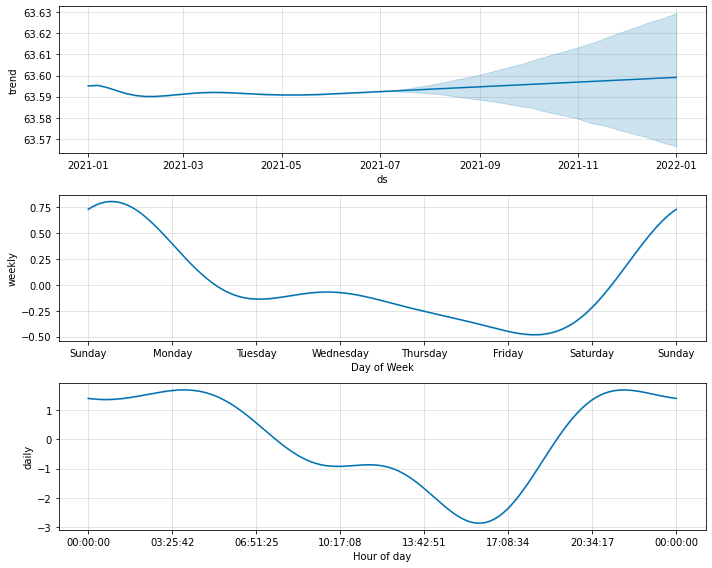

In [14]:
# model component
p = m.plot_components(forecast, figsize=(10, 8))